# Determining joint visiblity of solar coordinates

between any two instruments or reference frames

This tutorial demonstrates how to determine if a solar location observed by one instrument is also observed by a second instrument. For example, this can be used to determine if a flare seen by SDO/AIA is also seen by Solar Orbiter/STIX. This will be the example used in this tutorial.

Required packages:
- sunpy
- astropy
- os

Optional packages:
- heliopy 
- stixdcpy
- matplotlib


## Step 0: Furnish SPICE kernels

This step is not needed for STIX and AIA, as trajectory information can be obtained from their databases. However, if wishing to check visibility with other instruments or planetary bodies, usinge the required SPICE kernels might be the only way to do it.

SPICE kernels can be downloaded [here](https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS) for various instruments and [here](https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS/repos/solar-orbiter/browse) for Solar Orbiter. 

Kernels can also be obtained and furnished via an old version of [heliopy](https://github.com/heliopython/heliopy) (its replacement [astrospice](https://github.com/astrospice/astrospice) is under development). Install via: 
```bash
pip install helopy==0.15.4
```

In [4]:
import heliopy.data.spice as spicedata
import heliopy.spice as hespice

- using local copy of kernel

In [ ]:
path_kernel="/path/to/local/kernel/"

In [ ]:
cwd=os.getcwd()
# Change the CWD to the given path. Necessary to load correctly all kernels
os.chdir(path_kernel)
spice_kernel = hespice.Kernel('solo_ANC_soc-flown-mk.tm')
#spice_kernel = hespice.Kernel('solo_ANC_soc-pred-mk.tm') #use the predicted kernel if no as-flown kernel available
hespice.furnish(spice_kernel)
os.chdir(cwd)

- using heliopy

In [83]:
spice_kernel= spicedata.get_kernel('solo')
hespice.furnish(spice_kernel)

## Step 1: Get observer information and reference coordinate

Observer information is used for building the coordinate frame as seen by a particular spacecraft. If you already have solar maps from each instrument available, this is trivial. 

Without solar maps, and for the case of STIX and AIA, we use [stixdcpy](https://github.com/drhlxiao/stixdcpy) and [sunpy/drms](https://github.com/sunpy/drms) respectively. For other observers, such as STEREO or planetary bodies, please see _get_observer()_ and related functions [here](https://github.com/elastufka/solar_all_purpose/blob/main/spacecraft_utils.py) that use a properly loaded SPICE kernel.


#### using solar maps

warning - if your solar maps are from very different datetimes, this will still work! 

In [ ]:
import sunpy.map

stix_map=sunpy.map.Map('sample_data/stix_fulldisk.fits')
aia_map=sunpy.map.Map('sample_data/aia_fulldisk.fits')
solo_refcoord=stix_map.reference_coordinate
sdo_refcoord=aia_map.reference_coordinate

#### without solar maps

In [26]:
from stixdcpy import ancillary as anc
import drms #included with sunpy
from sunpy.coordinates.frames import HeliocentricEarthEcliptic,HeliographicStonyhurst
from astropy import units as u
from astropy.coordinates import SkyCoord

In [84]:
#time period of interest
start_utc='2022-01-01T00:00:00'
end_utc='2022-01-01T00:01:00'

get Solar Orbiter ephemeris

In [85]:
eph=anc.Ephemeris.from_sdc(start_utc=end_utc, end_utc=end_utc, steps=1)
solo_hee=eph.data['orbit']['solo_hee'][0] #HEE (x,y,z) in km
solo_hee

[146042282.8139231, -30401160.44217085, 3150425.4010110497]

transform ephemeris to sunpy Observer object and reference coordinate

In [87]:
solo_observer=SkyCoord(solo_hee[0]*u.km,solo_hee[1]*u.km,solo_hee[2]*u.km,frame=HeliocentricEarthEcliptic,representation_type='cartesian',obstime=start_utc)
solo_observer

<SkyCoord (HeliocentricEarthEcliptic: obstime=2022-01-01T00:00:00.000): (x, y, z) in km
    (1.46042283e+08, -30401160.44217085, 3150425.40101105)>

In [90]:
solo_refcoord=SkyCoord(0*u.arcsec,0*u.arcsec,observer=solo_observer,frame='helioprojective',obstime=start_utc) #helioprojective instead of stonyhurst
solo_refcoord

<SkyCoord (Helioprojective: obstime=2022-01-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-01-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, km)
    (-11.53553075, -0.39308444, 1.49206247e+08)>): (Tx, Ty) in arcsec
    (0., 0.)>

get SDO ephemeris from AIA image headers

In [25]:
client = drms.Client()
kstr='HGLN_OBS,HGLT_OBS,DSUN_OBS,RSUN_OBS,DATE-OBS,RSUN_REF,EXPTIME,INSTRUME,WAVELNTH,WAVEUNIT,TELESCOP,LVL_NUM,CROTA2'
qstr=f'aia.lev1_uv_24s[{start_utc}/1m@30s]' #if no UV data available can also try EUV: qstr=f'aia.lev1_euv_12s[{start_utc}/1m@30s]'
df = client.query(qstr, key=kstr)
meta=df.iloc[0].to_dict()
meta
    

{'HGLN_OBS': -0.014047,
 'HGLT_OBS': -3.004365,
 'DSUN_OBS': 147090515416.61,
 'RSUN_OBS': 976.003384,
 'DATE-OBS': '2021-12-31T23:59:50.13Z',
 'RSUN_REF': 696000000.0,
 'EXPTIME': 2.901274,
 'INSTRUME': 'AIA_3',
 'WAVELNTH': 1600,
 'WAVEUNIT': 'angstrom',
 'TELESCOP': 'SDO/AIA',
 'LVL_NUM': 1.0,
 'CROTA2': 0.019745}

In [132]:
sdo_observer=SkyCoord(meta['HGLN_OBS']*u.deg,meta['HGLT_OBS']*u.deg,meta['DSUN_OBS']*u.m,frame=HeliographicStonyhurst,obstime=meta['DATE-OBS'])
sdo_observer

<SkyCoord (HeliographicStonyhurst: obstime=2021-12-31T23:59:50.130, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.014047, -3.004365, 1.47090515e+11)>

In [89]:
sdo_refcoord=SkyCoord(0*u.arcsec,0*u.arcsec,observer=sdo_observer,frame='helioprojective',obstime=meta['DATE-OBS']) #helioprojective instead of stonyhurst
sdo_refcoord

<SkyCoord (Helioprojective: obstime=2021-12-31T23:59:50.130, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-31T23:59:50.130, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.014047, -3.004365, 1.47090515e+11)>): (Tx, Ty) in arcsec
    (0., 0.)>

In [95]:
%matplotlib inline

Text(0.5, 1.0, 'Positions of SOLO and SDO at 2022-01-01T00:00:00')

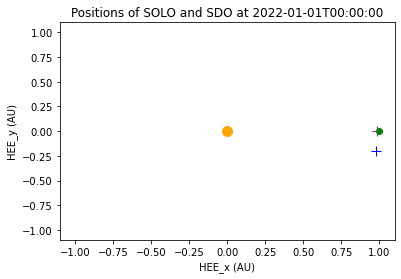

In [149]:
#plot the spacecraft locations to double-check
fig,ax=plt.subplots()
ax.plot(solo_hee[0]*u.km.to(u.AU),solo_hee[1]*u.km.to(u.AU),marker='+',markersize=10,color='b')
ax.plot(sdo_hee.x.to(u.AU),sdo_hee.y.to(u.AU),marker='+',markersize=10,color='m')
ax.plot(0,0,marker='o',color='orange',markersize=10) #Sun
ax.plot(1,0,marker='o',color='green') #Earth
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_xlabel('HEE_x (AU)')
ax.set_ylabel('HEE_y (AU)')
ax.set_title(f'Positions of SOLO and SDO at {start_utc}')

In [106]:
sdo_hee=sdo_observer.transform_to(HeliocentricEarthEcliptic)
sdo_hee.representation_type='cartesian'
sdo_hee

<SkyCoord (HeliocentricEarthEcliptic: obstime=2021-12-31T23:59:50.130): (x, y, z) in m
    (1.4709051e+11, -34263590.36255646, -17176508.01913204)>

## Step 2: check if coordinates are visible from both instruments

Example 1: A solar flare was seen by STIX at location (100",500"). Check if it is seen on-disk by AIA.

In [91]:
flare_coord=SkyCoord(100*u.arcsec,500*u.arcsec,frame=solo_refcoord.frame) #with map, can also use frame=stix_map.frame
flare_coord

<SkyCoord (Helioprojective: obstime=2022-01-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-01-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, km)
    (-11.53553075, -0.39308444, 1.49206247e+08)>): (Tx, Ty) in arcsec
    (100., 500.)>

In [92]:
flare_coord.transform_to(sdo_refcoord.frame) #with map, can also use frame=aia_map.frame

<SkyCoord (Helioprojective: obstime=2021-12-31T23:59:50.130, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-31T23:59:50.130, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.014047, -3.004365, 1.47090515e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (-67.42117094, 544.71585244, 1.46514845e+08)>

Example 2: An active region was seen by AIA at location (-800",150"). Check if it is seen on-disk by STIX.

In [93]:
ar_coord=SkyCoord(-800*u.arcsec,150*u.arcsec,frame=sdo_refcoord.frame)
ar_coord

<SkyCoord (Helioprojective: obstime=2021-12-31T23:59:50.130, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-12-31T23:59:50.130, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.014047, -3.004365, 1.47090515e+11)>): (Tx, Ty) in arcsec
    (-800., 150.)>

In [94]:
ar_coord.transform_to(solo_refcoord.frame)

<SkyCoord (Helioprojective: obstime=2022-01-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-01-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, km)
    (-11.53553075, -0.39308444, 1.49206247e+08)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (-665.0225517, 124.44952793, 1.48710997e+11)>

In [148]:
#compare with solar angular radius as seen by SOLO:
import sunpy.map
solo_rsun=sunpy.map.solar_angular_radius(solo_refcoord)
solo_rsun

<Angle 961.74891249 arcsec>

In the dates chosen for this example, the viewpoints of Solar Orbiter and SDO are very similar. Try different dates or flare coordinates to see what happens! The _.transform_to()_ function will return NaN if the coordinate in the desired reference frame is unable to be calculated (for example, behind the disk). You can also use _sunpy.map.maputils.coordinate_is_on_solar_disk(coordinate)_ to check if the transformed coordinate is on-disk.